In [1]:
import os
import glob
import sys
from pathlib import Path
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
singleElectronDataset = '../data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
singlePhotonDataset = '../data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'


def read_data(filepath):
    with h5py.File(filepath, 'r') as f:
        print("Keys:", list(f.keys()))
        data = f['X'][:]
        print("Shape:", data.shape) 
    return data

electronData = read_data(singleElectronDataset)
photonData = read_data(singlePhotonDataset)



Keys: ['X', 'y']
Shape: (249000, 32, 32, 2)
Keys: ['X', 'y']
Shape: (249000, 32, 32, 2)


#### Transpose the data to channels_first format

In [3]:
electronData = np.transpose(electronData, (0, 3, 1, 2))
photonData = np.transpose(photonData, (0, 3, 1, 2))

print("Electron data shape:", electronData.shape)
print("Photon data shape:", photonData.shape)

Electron data shape: (249000, 2, 32, 32)
Photon data shape: (249000, 2, 32, 32)


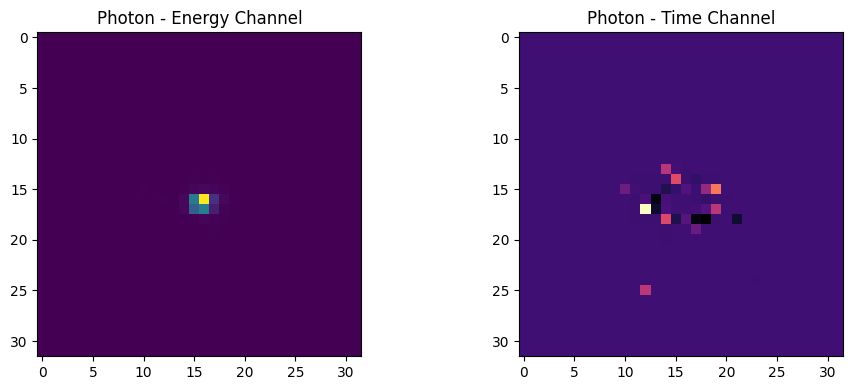

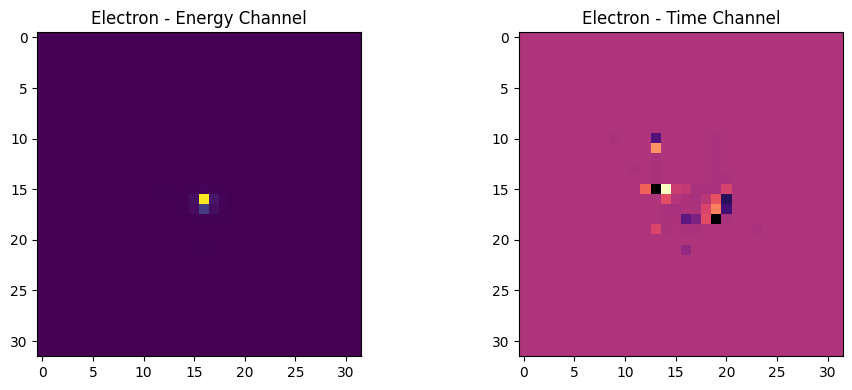

In [4]:
def plot_channels(sample, title_prefix):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(sample[0], cmap='viridis')
    axes[0].set_title(f"{title_prefix} - Energy Channel")
    axes[1].imshow(sample[1], cmap='magma')
    axes[1].set_title(f"{title_prefix} - Time Channel")
    plt.tight_layout()
    plt.show()

plot_channels(photonData[1], "Photon")
plot_channels(electronData[1], "Electron")

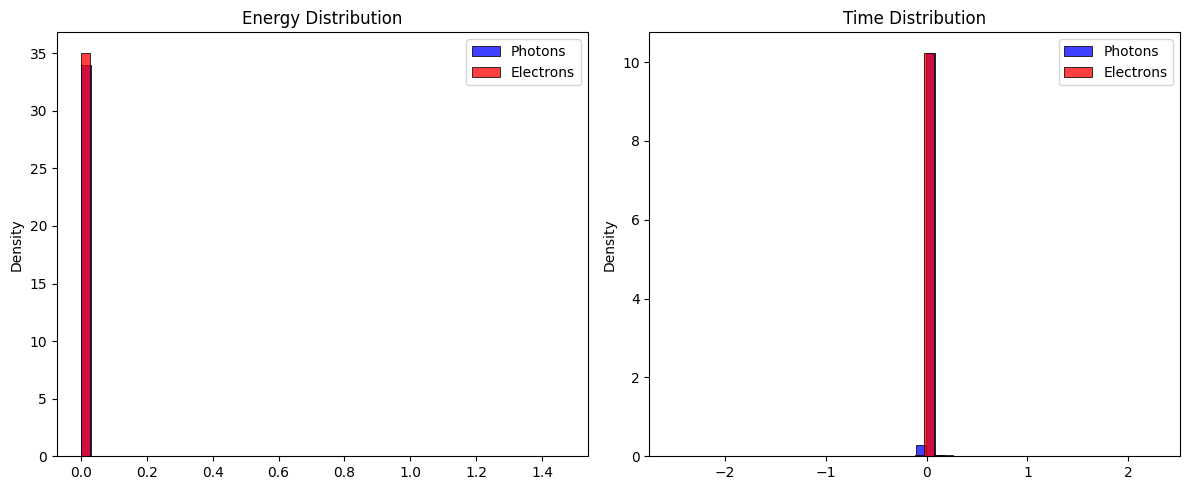

In [5]:
# Compute statistics on a subset
SAMPLE_COUNT = 10000
photonEnergy = photonData[:SAMPLE_COUNT, 0]  # Energy channel
photonTime = photonData[:SAMPLE_COUNT, 1]    # Time channel

electronEnergy = electronData[:SAMPLE_COUNT, 0]
electronTime = electronData[:SAMPLE_COUNT, 1]

# Plot histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(photonEnergy.flatten(), bins=50, color='blue', label='Photons', stat='density')
sns.histplot(electronEnergy.flatten(), bins=50, color='red', label='Electrons', stat='density')
plt.title("Energy Distribution")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(photonTime.flatten(), bins=50, color='blue', label='Photons', stat='density')
sns.histplot(electronTime.flatten(), bins=50, color='red', label='Electrons', stat='density')
plt.title("Time Distribution")
plt.legend()

plt.tight_layout()
plt.show()

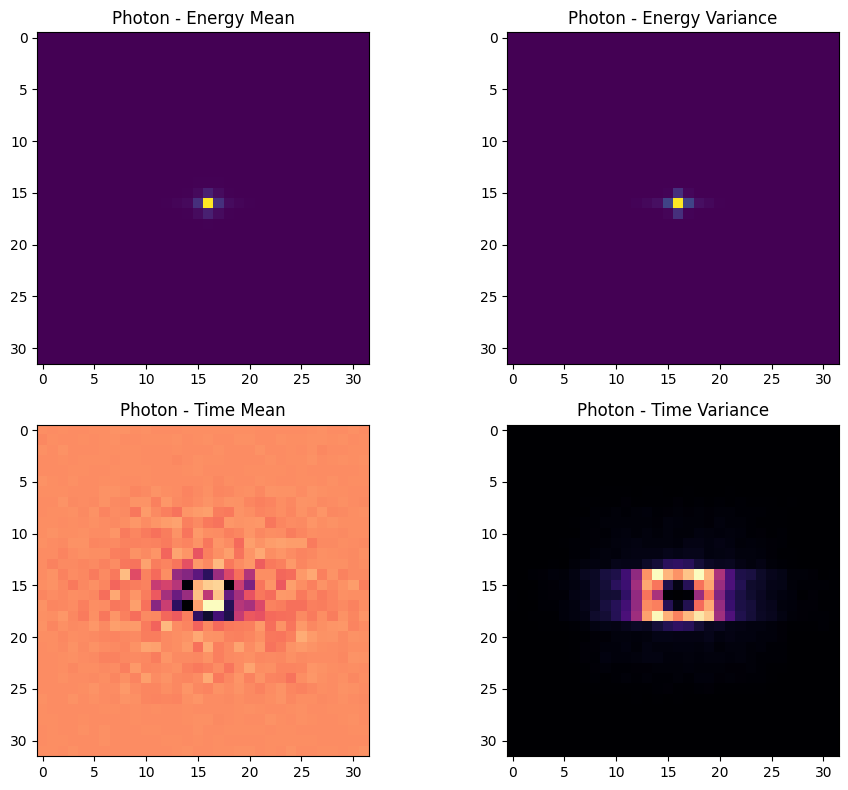

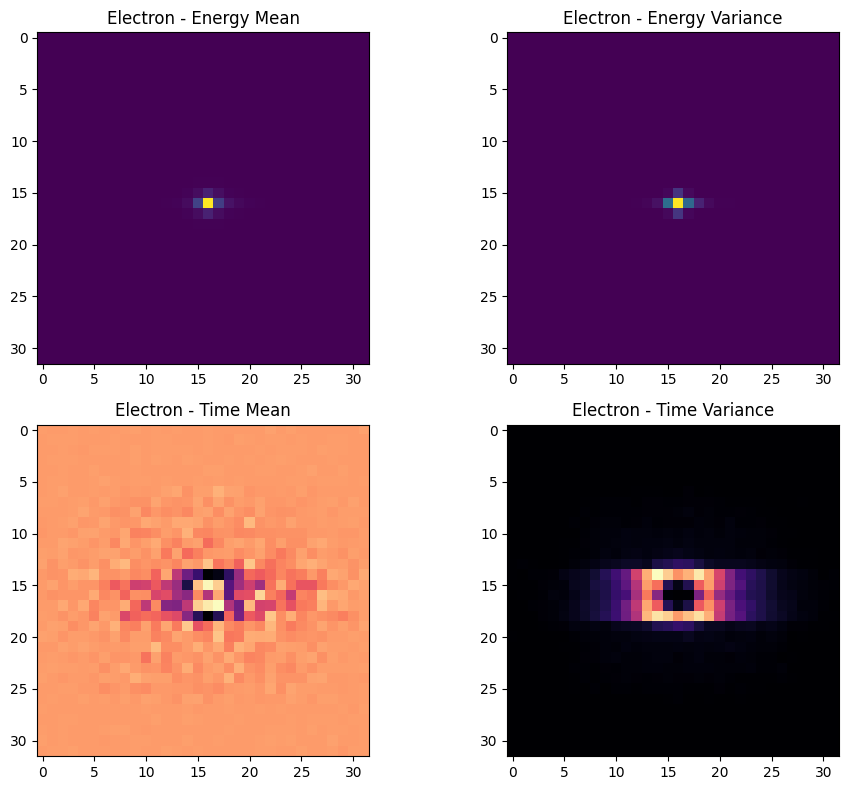

In [6]:
def plot_mean_var_heatmaps(data, label):
    energy_mean = np.mean(data[:, 0], axis=0)
    energy_var = np.var(data[:, 0], axis=0)
    time_mean = np.mean(data[:, 1], axis=0)
    time_var = np.var(data[:, 1], axis=0)

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes[0, 0].imshow(energy_mean, cmap='viridis')
    axes[0, 0].set_title(f"{label} - Energy Mean")
    axes[0, 1].imshow(energy_var, cmap='viridis')
    axes[0, 1].set_title(f"{label} - Energy Variance")
    axes[1, 0].imshow(time_mean, cmap='magma')
    axes[1, 0].set_title(f"{label} - Time Mean")
    axes[1, 1].imshow(time_var, cmap='magma')
    axes[1, 1].set_title(f"{label} - Time Variance")
    plt.tight_layout()
    plt.show()

plot_mean_var_heatmaps(photonData[:SAMPLE_COUNT], "Photon")
plot_mean_var_heatmaps(electronData[:SAMPLE_COUNT], "Electron")

### After normalizing the data in data_preprocess.py, check for the mean and std of the training dataset

In [20]:
src_path = Path.cwd().parent / "src"
sys.path.append(str(src_path))

In [ ]:
from utils import HDF5Dataset
from torch.utils.data import DataLoader, RandomSampler

proj_root_path = Path.cwd().parent
# print(proj_root_path)
train_file = proj_root_path / 'data/preprocessed/train_dataset.hdf5'
# print(train_file)
train_dataset = HDF5Dataset(train_file)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=RandomSampler(train_dataset))

X = next(iter(train_loader))[0]
print("Per-channel mean:", X.mean(dim=(0, 2, 3)))
print("Per-channel std:", X.std(dim=(0, 2, 3)))

Per-channel mean: tensor([ 0.0028, -0.0032])
Per-channel std: tensor([0.9817, 1.0945])


In [21]:
import torch
# checking for class imbalance in the training dataset
unique, counts = torch.unique(train_dataset.labels, return_counts=True)
print(dict(zip(unique.tolist(), counts.tolist())))

{0: 174300, 1: 174300}
